# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## 1. Import Libraries

In [1]:
%matplotlib inline
# python libraries
from matplotlib.patches import Rectangle
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
import sys
import pandas as pd

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from sklearn import decomposition
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package
from density_tree.density_forest import *
from density_tree.plots import plot_tsne, plot_pca
from helpers.plots import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18121947835378269430
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 2
}
incarnation: 16361703583763742234
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1"
]


In [2]:
class_to_remove = 1

## 2. Load Images

In [3]:
path = os.getcwd()

imgs, gt = load_data(path)

# gt to labels
# Next, we need to convert the ground truth (colors) to labels 
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

gt = gt_color_to_label(gt, colors)

images: 20 
ground truth images: 20 


### 2.2. Get patches

In [4]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)

(3902, 64, 64, 4)
(964, 64, 64, 4)


## 3. Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [5]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [6]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [7]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Buildings', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


### 3.1. Train CNN

In [8]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

In [9]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [10]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### 3.2. Prediction on Test Set

In [11]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# get accuracy as softmax pseudo-probability
y_pred_acc = np.max(y_pred, axis=-1)

# Get accuracy as margin between highest and second highest class
y_pred_acc_margin = get_acc_net_max_margin(y_pred)

3902/3902 [==============================] - 6s 2ms/step


In [12]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[..., np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

In [13]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

### 3.3. Accuracy Metrics (Test Set)

In [14]:
# Accuracy metrics
y_pred_flattened= np.asarray(y_pred_label.flatten()).astype('int')
y_test_flattened= np.asarray(y_test_nostride.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

     Buildings      0.802     0.978     0.881    470587
         Trees      0.885     0.869     0.877    545015
         Grass      0.960     0.831     0.891    612397
     Bare Soil      0.880     0.734     0.801     66093
         Water      0.873     0.816     0.844     18705
      Railways      0.052     0.085     0.064     18526
Swimming Pools      0.000     0.000     0.000     10386

   avg / total      0.875     0.866     0.866   1741709

Overall accuracy: 86.594 %


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 4. Certainty using Density Forest
### 4.1. Retrieve Activations, PCA, t-SNE

In [15]:
# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20

# get activations for training Density Forest
act_train = get_activations(imgs, model_unet, layer_idx, x_train, ids_train, batch_size=160, patch_size=64, stride=64)

100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


In [16]:
# get activations for seen classes

# retain only activation weights for which there is a ground truth
filter_seen = (y_train_label != 0) & (y_train_label != class_to_remove)
act_train_seen = np.concatenate(act_train)[filter_seen] 

# all but those belonging to background
act_train = np.concatenate(act_train)[y_train_label != 0]

In [17]:
# get activations for testing Density Forest
act_test = get_activations(imgs, model_unet, layer_idx, x_test, ids_test, batch_size=160, patch_size=64, stride=32)

# remove test activations overlap
act_test = remove_overlap(imgs, np.concatenate(act_test), ids_test, patch_size=64, stride=32) 

# all labels, including background
act_test = np.concatenate(act_test, axis=0)[y_test_nostride < np.infty] # convert to 1D

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


In [18]:
# get balanced data subset to show in figure
pts_per_class = 100  # same number of points per class
dataset_subset_indices = []
for class_label in range(1, 9):
    ds_subset_ind = np.where(y_test_nostride[y_test_nostride<np.infty]==class_label)[0]
    dataset_subset_indices.append(np.random.choice(ds_subset_ind, size=pts_per_class, replace=False))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.002s...
[t-SNE] Computed neighbors for 800 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 1.468249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.274879
[t-SNE] Error after 500 iterations: 0.336920


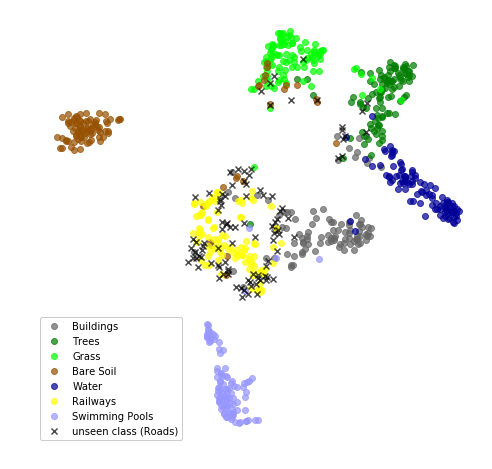

In [19]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

plot_tsne(tsne_all, class_to_remove, classes_to_keep, pts_per_class, colors, names)

In [20]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=5)
pca.fit(act_train)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train_seen = pca.transform(act_train_seen)

# transform test set activations
act_test = pca.transform(act_test)

Variance explained by first 5 components: 0.96


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.000s...
[t-SNE] Computed neighbors for 800 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 1.349376
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.346840
[t-SNE] Error after 500 iterations: 0.333909


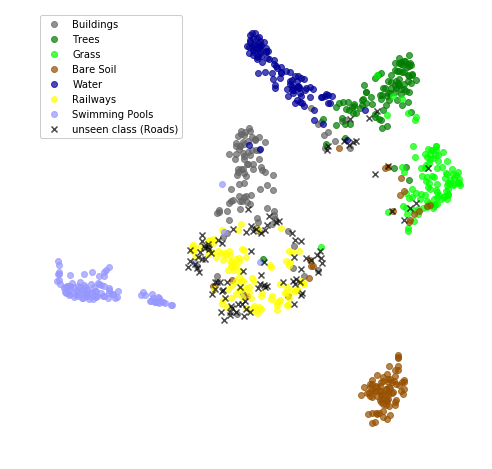

In [21]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

# plot
plot_tsne(tsne_all, class_to_remove, classes_to_keep, pts_per_class, colors, names)

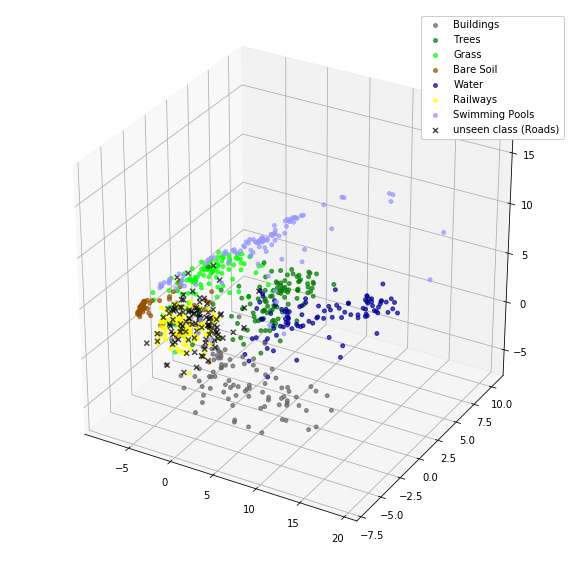

Variance explained by first 3 components: 0.89


In [22]:
# plot PCA point
plot_pca(act_test, class_to_remove, classes_to_keep, names, dataset_subset_indices, colors)

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

# 4.2. Train Density Forest

**Parameters importance:**
- `n_trees`: minor relevance (10 is enough)
- `min_subset`: important, smaller number <-> more clusters (requires `subset_data` to be high enough)
- `subset_data`: irrelevant, but should be higher if `min_subset` is lower
- `max_depth`: important, greater depth <-> more clusters
- `fact_improvement`: important, smaller minimum factor <-> more clusters
- `n_max_dim`: unimportant, better to set to 0


In [87]:
n_trees = 50
max_depth = 1
subsample_pct = .0002
min_subset = .1
fact_improvement = 1.4
n_max_dim = -1
n_jobs=-1

root_nodes_seen = df_create(act_train_seen, max_depth=max_depth, min_subset=min_subset, n_trees=n_trees, 
                                        n_max_dim=n_max_dim, subsample_pct=subsample_pct, n_jobs=n_jobs, verbose=10, 
                                        fact_improvement=fact_improvement)

Number of points on which to train each tree: 1400
Minimum number of points in each leaf: 140


[Parallel(n_jobs=40)]: Done   7 out of  50 | elapsed:    1.7s remaining:   10.6s
[Parallel(n_jobs=40)]: Done  13 out of  50 | elapsed:    1.8s remaining:    5.2s
[Parallel(n_jobs=40)]: Done  19 out of  50 | elapsed:    2.0s remaining:    3.3s
[Parallel(n_jobs=40)]: Done  25 out of  50 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=40)]: Done  31 out of  50 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=40)]: Done  37 out of  50 | elapsed:    2.4s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  43 out of  50 | elapsed:    2.6s remaining:    0.4s
[Parallel(n_jobs=40)]: Done  50 out of  50 | elapsed:    2.7s finished


Number of created root nodes: 50
Mean number of clusters created per tree: 3


In [88]:
# get probabilities for all images
probas = df_traverse_batch(act_test, root_nodes_seen, n_jobs=-1, 
                           thresh=0, batch_size=10000, verbosity=10, standardize=False)

Total steps: 394
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:   10.3s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:   10.8s
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:   20.1s
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:   21.4s
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   28.9s
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed:   31.2s
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   35.9s
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed:   41.2s
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed:   47.5s
[Parallel(n_jobs=40)]: Done 185 tasks      | elapsed:   51.5s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:   58.3s
[Parallel(n_jobs=40)]: Done 233 tasks      | elapsed:  1.1min
[Parallel(n_jobs=40)]: Done 258 tasks      | elapsed:  1.2min
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:  1.3min
[Parallel(n_jobs=40)]: Done 312 tasks      | elapsed:  1.4min
[Paralle

### 4.3. Post-Treatment

In [89]:
# reshape probas to (n_patches, patch_size, patch_size)
patches_start = get_offset(imgs, 64, 64, 16, 16) # idx of first patch in image
patches_end = get_offset(imgs, 64, 64, 16, 20) # idx of first patch in image
n_patches = patches_end - patches_start
probas_seen_im = np.reshape(probas, (n_patches,patch_size,patch_size))

# transformations
#probas_seen_im[probas_seen_im==0]=1e-5  # for log
#probas_seen_im = np.log(probas_seen_im)
probas_seen_im -= np.nanmin(probas_seen_im)
probas_seen_im /= np.nanmax(probas_seen_im)
#probas_seen_im = 1-probas_seen_im

# remove outliers
#probas_seen_im[abs(probas_seen_im - np.nanmean(probas_seen_im)) > m * np.nanstd(probas_seen_im)] = np.nan

In [90]:
# save probabilities corresponding to an image in an array
probas_imgs = [] # (n_imgs, n_patches, patch_size, patch_size)
for idx_im in ids_test:
    patches_start = get_offset(imgs, 64, 64, 16, idx_im) # idx of first patch in image
    patches_end = get_offset(imgs, 64, 64, 16, idx_im+1) # idx of last patch in image
    probas_im = np.asarray(probas_seen_im[patches_start:patches_end])
    probas_imgs.append(probas_im)

### 4.4. Figures, Tables

In [91]:
# calculate average certainty by Density Forest
# support for all labels in y_true
support = np.unique(y_test_flattened, return_counts=True)[1][1:]

probas_patches = np.concatenate(probas_imgs) # all patches concatenated (like y_test)
av_cert = []
nans = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(probas_patches[y_test_nostride==label]))
    nans.append(np.sum(np.isnan(probas_patches[y_test_nostride==label]))/np.sum(np.ones(np.shape(probas_patches[y_test_nostride==label]))))

av_cert_w = (av_cert*support)/sum(support)
av_cert = np.asarray(av_cert)
nans = np.asarray(nans)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f, nans: %.2f%%" % (names[idx + 1], w, nans[idx]*100))


# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

av_cert_w = (av_cert*support)/sum(support)
cert_unseen_w = av_cert_w[class_to_remove - 1]
cert_seen_w = np.nanmean(np.asarray(av_cert)[av_cert_w != cert_unseen])

print("Average certainty unseen class:\t%.5f" % cert_unseen)
print("Average certainty seen classes:\t%.5f" % cert_seen)
print("Ratio between support-weighted cert. of seen classes / unseen class:\t%.3f" % (cert_seen_w / cert_unseen_w))

Average certainty within class:
          Roads: 0.01209, nans: 0.00%
      Buildings: 0.01366, nans: 0.00%
          Trees: 0.10118, nans: 0.00%
          Grass: 0.22856, nans: 0.00%
      Bare Soil: 0.00899, nans: 0.00%
          Water: 0.04882, nans: 0.00%
       Railways: 0.00401, nans: 0.00%
 Swimming Pools: 0.00009, nans: 0.00%
Average certainty unseen class:	0.01209
Average certainty seen classes:	0.05790
Ratio between support-weighted cert. of seen classes / unseen class:	18.753


In [92]:
# print to log file
df = pd.DataFrame(data={'Average Certainty':av_cert,
                        'Nans':nans}, index=names[1:])

df.index.name = 'Class'
with open("models_out/acc_DF_class_" + str(class_to_remove) + ".csv", 'w') as f:
    print(df.to_latex(float_format='%.3f'), file=f)  # Python 3.x

In [93]:
# calculate average certainty by Network
av_cert = []
nans = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(y_pred_acc[y_test_nostride==label]))
av_cert = np.asarray(av_cert)
nans = np.asarray(nans)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f" % (names[idx + 1], w))

# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

av_cert_w = (av_cert*support)/sum(support)
cert_unseen_w = av_cert_w[class_to_remove - 1]
cert_seen_w = np.nanmean(np.asarray(av_cert)[av_cert_w != cert_unseen])

print("Average certainty unseen class:\t%.5f" % cert_unseen)
print("Average certainty seen classes:\t%.5f" % cert_seen)
print("Ratio between support-weighted cert. of seen classes / unseen class:\t%.3f" % (cert_seen_w / cert_unseen_w))

Average certainty within class:
          Roads: 0.79956
      Buildings: 0.94859
          Trees: 0.88913
          Grass: 0.86672
      Bare Soil: 0.86071
          Water: 0.87872
       Railways: 0.73431
 Swimming Pools: 0.92506
Average certainty unseen class:	0.79956
Average certainty seen classes:	0.87189
Ratio between support-weighted cert. of seen classes / unseen class:	4.689


### 4.5. Accuracy ratios

| Accuracy indicator | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 
| ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| 1A | 4.689 |  | |  | | | | |
| 1B | 4.980 | 6.792 | 6.038 | 3.489 | 53.949 | 165.043 | 153.863 | 179.750 |
| 2A | 123.389 | 475.483 | 16.604 | 5.188 | 91.749 | 12332.699 | 43.022 | 79770.728 |
| 2B | 4.840 | 4.512 | 4.234 | 3.256 | 108.226 | 409.266 | 104.420 | 8511.800 |

**Abbreviations**
1. Network
  1. `softmax` pseudo-probability ratio weighted
  2. `max-margin` ratio weighted
2. Density Forest
  1. average weighted accuracy ratios (`DF with randomization`)
  2. average weighted accuracy ratios (`DF std. with randomization`)
  
#### Observations
- *Higher number of splits* (greater depth, min subset of data per leaf smaller): better ratio, but roads and buildings both very low

In [94]:
#net_msr = [4.689, 5.581, 5.007,]
net_margin = [4.980 , 6.792, 6.038 , 3.489 , 53.949 , 165.043 , 153.863 , 179.750]
df = [123.389 , 475.483 , 16.604 , 5.188, 91.749 , 12332.699 , 43.022 , 79770.728]
df_std = [4.840 , 4.512 , 4.234 , 3.256 , 108.226 , 409.266 , 104.420 , 8511.800]

cl_idx = 10
#print("%.3f" % (np.dot(net_msr[:cl_idx],support[:cl_idx])/sum(support[:cl_idx])))
print("%.3f" % (np.dot(net_margin[:cl_idx],support[:cl_idx])/sum(support[:cl_idx])))
print("%.3f" % (np.dot(df[:cl_idx],support[:cl_idx])/sum(support[:cl_idx])))
print("%.3f" % (np.dot(df_std[:cl_idx],support[:cl_idx])/sum(support[:cl_idx])))

9.983
603.893
50.428


### Recall-Precision Curves

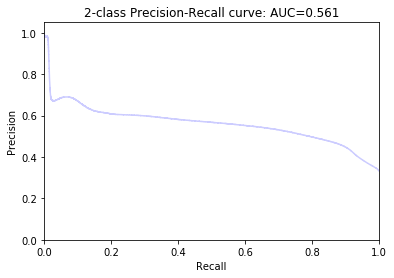

In [95]:
# DF
#y_scores = -np.log(probas_patches+1e-5).flatten()
y_scores = -probas_patches.flatten()
y_true = (y_test_nostride != y_pred_label).flatten()

filt = y_test_nostride.flatten()!=0
y_true = y_true[filt]
y_scores = y_scores[filt]
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plot_precision_recall(precision, recall, s_name="../Figures/DF/AUC/AUC_pred_wo_cl_" + str(class_to_remove) + "_DF.pdf")#y_scores = probas_patches.flatten()

/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


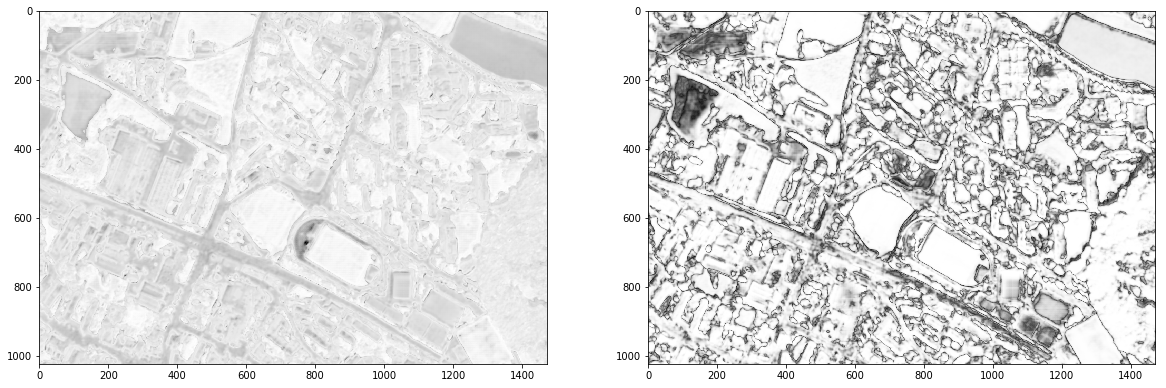

In [96]:
# show image of DF uncertainty vs. max margin uncertainty
img_idx=3
acc_im_ = convert_patches_to_image(imgs, probas_patches[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im = np.log(acc_im_)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(acc_im[...,0], cmap='gray')
axes[1].imshow(y_pred_acc_imgs[img_idx][...,0], cmap='gray')